In [6]:
import os
import pandas as pd
import numpy as np
import ast
from pathlib import Path
import torch
from torch.nn import functional as F
from matplotlib import pyplot as plt
from encoders_task_1 import EncoderBasedClassifier, CDLDataModule, ContrastiveClassifier, FinetuningClassifier
from sklearn.decomposition import PCA
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

torch.cuda.is_available()



True

(488, 1)


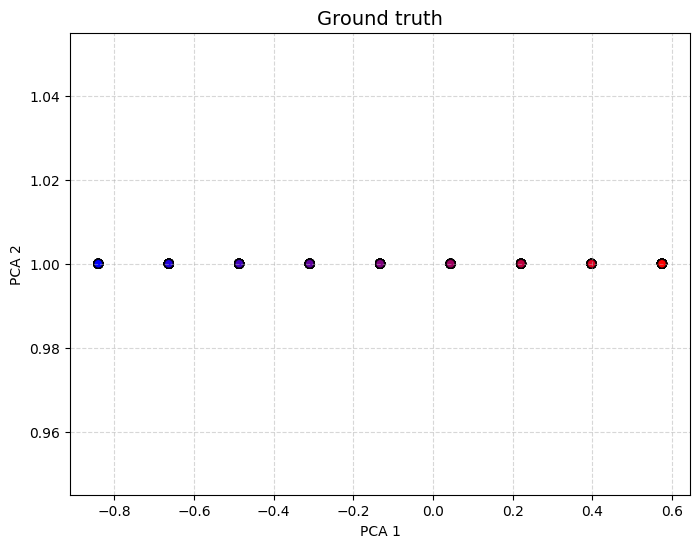

In [31]:
csv_path = '../data/annotated/task_1_annotation.csv'
df = pd.read_csv(csv_path)
def get_soft_label(row):
    label_aggregate_map = {"non-inflation-related": 0, "inflation-related": 0.5, "inflation-cause-dominant": 1}
    annotator_columns = [col for col in row.index if col.startswith('annotator_')]
    likelihoods = sum([label_aggregate_map[label]/4 for label in row[annotator_columns].values.tolist()])
    return [1-likelihoods, likelihoods]

df["soft_label"] = df.apply(get_soft_label, axis=1)
soft_labels = np.vstack(df['soft_label'].to_numpy()) 
# Use probability of class 1 (second element could also be used)
p_class1 = soft_labels[:, 0]  # range [0,1]

# Map [1,0] = red, [0,1] = blue, intermediate = gradient
colors = np.zeros((len(p_class1), 3))  # RGB
colors[:, 0] = p_class1        # red channel
colors[:, 2] = 1 - p_class1    # blue channel
pca = PCA(n_components=1)
embeddings = pca.fit_transform(soft_labels)
print(embeddings.shape)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(embeddings[:, 0], [1]*len(embeddings), c=colors, s=40, alpha=0.8, edgecolor='k')
plt.title(f"Ground truth", fontsize=14)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True, linestyle="--", alpha=0.5)
plt.savefig(f"./results/embeddings_ground_truth.png", dpi=300, bbox_inches='tight')
plt.show()

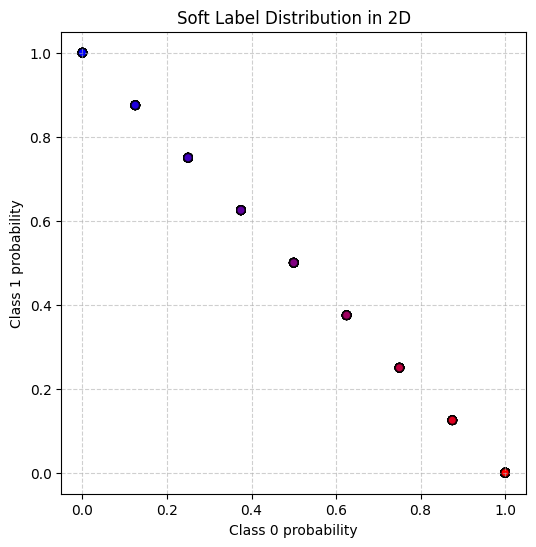

In [ ]:


def plot_soft_labels_2d(df, column="soft_label"):
    # Convert list of floats into two columns
    df_expanded = pd.DataFrame(df[column].tolist(), columns=["class_0", "class_1"])
    
    # Define colors as a gradient from red -> blue depending on class_1 prob
    colors = [(r, 0, b) for r, b in zip(1 - df_expanded["class_1"], df_expanded["class_1"])]
    
    # Scatter plot in 2D
    plt.figure(figsize=(6,6))
    plt.scatter(df_expanded["class_0"], df_expanded["class_1"], c=colors, alpha=0.7, edgecolor="k")
    
    # Axis settings
    plt.xlabel("Class 0 probability")
    plt.ylabel("Class 1 probability")
    plt.title("Soft Label Distribution in 2D")
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

plot_soft_labels_2d(df, column="soft_label")
visualize_softlabel_embeddings(df, exp="Ground truth", mode="Ground truth", pca=True):


In [2]:

def load_and_plot_training_log(tsv_path, loss= "sscl", smoothing_window=3, finetune=False):
    # Load the TSV
    df = pd.read_csv(tsv_path, sep=",")
    
    # Combine duplicate rows per step by grouping
    df_grouped = df.groupby(["epoch", "step"]).first().reset_index()

    # Sort by step to ensure chronological plotting
    df_grouped = df_grouped.sort_values("step")

    # Convert columns to numeric (in case of missing/invalid data)
    for col in df_grouped.columns:
        if col not in ["epoch", "step"]:
            df_grouped[col] = pd.to_numeric(df_grouped[col], errors="coerce")

    # Define smoothing function
    def smooth(series, window=smoothing_window):
        return series.rolling(window=window, min_periods=1, center=True).mean()

    # Plotting
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    axs = axs.flatten()

    if not finetune:
        try:
            # Train  loss
            axs[0].plot(df_grouped["step"], smooth(df_grouped[f"train_mae_loss_epoch"]), label="train_mae_loss_epoch")
            axs[0].plot(df_grouped["step"], smooth(df_grouped[f"train_mae_loss_step"]), label="train_mae_loss_step", linestyle='--')
            axs[0].set_title("Train MAE Loss (Smoothed)")
            axs[0].legend()
            axs[0].set_xlabel("Step")
            axs[0].set_ylabel("Loss")
        except KeyError:
            pass

        try:
            # Train SCL loss
            axs[1].plot(df_grouped["step"], smooth(df_grouped[f"train_{loss}_loss_epoch"]), label=f"train_{loss}_loss_epoch")
            axs[1].plot(df_grouped["step"], smooth(df_grouped[f"train_{loss}_loss_step"]), label=f"train_{loss}_loss_step", linestyle='--')
            axs[1].set_title("Train SCL Loss (Smoothed)")
            axs[1].legend()
            axs[1].set_xlabel("Step")
            axs[1].set_ylabel("Loss")

            # Validation MAE loss
            axs[3].plot(df_grouped["step"], smooth(df_grouped["val_mae_loss"]), label="val_mae_loss", color="orange")
            axs[3].set_title("Validation MAE Loss (Smoothed)")
            axs[3].legend()
            axs[3].set_xlabel("Step")
            axs[3].set_ylabel("Loss")
        except KeyError:
            pass

    else:
        # Finetune MAE loss
        axs[0].plot(df_grouped["step"], smooth(df_grouped[f"train_mae_loss_epoch"]), label="train_mae_loss_epoch")
        axs[0].plot(df_grouped["step"], smooth(df_grouped[f"train_mae_loss_step"]), label="train_mae_loss_step", linestyle='--')
        axs[0].set_title("Train MAE Loss (Smoothed)")
        axs[0].legend()
        axs[0].set_xlabel("Step")
        axs[0].set_ylabel("Loss")

        # Validation MAE loss
        axs[3].plot(df_grouped["step"], smooth(df_grouped["val_mae_loss"]), label="val_mae_loss", color="orange")
        axs[3].set_title("Validation MAE Loss (Smoothed)")
        axs[3].legend()
        axs[3].set_xlabel("Step")
        axs[3].set_ylabel("Loss")

    # Validation avg MD
    axs[2].plot(df_grouped["step"], smooth(df_grouped["val_avg_MD"]), label="val_avg_MD", color="green")
    axs[2].set_title("Validation Avg MD (Smoothed)")
    axs[2].legend()
    axs[2].set_xlabel("Step")
    axs[2].set_ylabel("Metric")

    
    exp = tsv_path.split('/')[2]
    fig.suptitle(exp)
    fig.savefig(f"./results/{exp}/training_progress.png", dpi=300, bbox_inches='tight')
    plt.tight_layout()
    plt.show()


In [3]:


def get_embeddings(model, exp="mle-empirical-frequency", batch_size=4, force=False):
    model.eval()
    device = model.device
    data = CDLDataModule(batch_size=batch_size)
    data.setup("fit")
    train_dataloader = data.train_dataloader()
    val_dataloader = data.val_dataloader()
    data.setup(stage="test")
    test_dataloader = data.test_dataloader()
    train_labels = []
    train_embeddings = []
    valid_embeddings = []
    valid_labels = []
    test_embeddings = []
    test_labels = []

    if not Path(f"./results/{exp}").exists():
        Path(f"./results/{exp}").mkdir()

    if not Path(f"./results/{exp}/embeddings_train.csv").exists() or force:
        with torch.no_grad():
            for i, batch in enumerate(train_dataloader):
                embedding = model(input_ids=batch["input_ids"].to(device), attention_mask=batch["attention_mask"].to(device))
                train_embeddings.extend(embedding.detach().cpu().tolist())
                train_labels.extend(batch["soft_label"].detach().cpu().tolist())
        df_train = pd.DataFrame()
        df_train["embeddings"] = train_embeddings
        df_train["labels"] = train_labels
        df_train.to_csv(f"./results/{exp}/embeddings_train.csv", index= False)
    else: 
        df_train = pd.read_csv(f"./results/{exp}/embeddings_train.csv")
        df_train['embeddings'] = df_train['embeddings'].apply(ast.literal_eval)
        df_train['labels'] = df_train['labels'].apply(ast.literal_eval)

    if not Path(f"./results/{exp}/embeddings_valid.csv").exists() or force:
        with torch.no_grad():
            for i, batch in enumerate(val_dataloader):
                embedding = model(input_ids=batch["input_ids"].to(device), attention_mask=batch["attention_mask"].to(device))
                valid_embeddings.extend(embedding.detach().cpu().tolist())
                valid_labels.extend(batch["soft_label"].detach().cpu().tolist())
        df_valid = pd.DataFrame()
        df_valid["embeddings"] = valid_embeddings
        df_valid["labels"] = valid_labels
        df_valid.to_csv(f"./results/{exp}/embeddings_valid.csv", sep =',', index= False)
    else:
        df_valid = pd.read_csv(f"./results/{exp}/embeddings_valid.csv", index_col=None)
        df_valid['embeddings'] = df_valid['embeddings'].apply(ast.literal_eval)
        df_valid['labels'] = df_valid['labels'].apply(ast.literal_eval)

    if not Path(f"./results/{exp}/embeddings_test.csv").exists() or force:
        with torch.no_grad():
            for i, batch in enumerate(test_dataloader):
                embedding = model(input_ids=batch["input_ids"].to(device), attention_mask=batch["attention_mask"].to(device))
                test_embeddings.extend(embedding.detach().cpu().tolist())
                test_labels.extend(batch["soft_label"].detach().cpu().tolist())
        df_test = pd.DataFrame()
        df_test["embeddings"] = test_embeddings
        df_test["labels"] = test_labels
        df_test.to_csv(f"./results/{exp}/embeddings_test.csv", index= False)
    else: 
        df_test = pd.read_csv(f"./results/{exp}/embeddings_test.csv", index_col=None)
        df_test['embeddings'] = df_test['embeddings'].apply(ast.literal_eval)
        df_test['labels'] = df_test['labels'].apply(ast.literal_eval)

    return df_train, df_valid, df_test

In [ ]:


def visualize_softlabel_embeddings(df, exp, mode, pca=True):
    """
    Visualize embeddings colored by soft labels.
    
    Args:
        df: pd.DataFrame with columns:
            - 'embeddings': list/array of L2-normalized vectors (dim=100)
            - 'labels': list/array of soft labels (dim=2, e.g. [0.7, 0.3])
    """
    # Convert to arrays
    embeddings = np.vstack(df['embeddings'].to_numpy())  # shape: (N, 100)
    soft_labels = np.vstack(df['labels'].to_numpy())      # shape: (N, 2)
    
    # Use probability of class 1 (second element could also be used)
    p_class1 = soft_labels[:, 0]  # range [0,1]
    
    # Map [1,0] = red, [0,1] = blue, intermediate = gradient
    colors = np.zeros((len(p_class1), 3))  # RGB
    colors[:, 0] = p_class1        # red channel
    colors[:, 2] = 1 - p_class1    # blue channel
    # green channel stays 0 for pure red-blue blending
    
    if pca:
        # Reduce embeddings to 2D with PCA
        pca = PCA(n_components=1)
        embeddings = pca.fit_transform(embeddings)
        print(embeddings.shape)
    
    # Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(embeddings[:, 0], [1]*len(embeddings), c=colors, s=40, alpha=0.8, edgecolor='k')
    plt.title(f"{exp} ({mode})", fontsize=14)
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.savefig(f"./results/{exp}/embeddings_{exp}_{mode}.png", dpi=300, bbox_inches='tight')
    plt.show()

Map: 100%|██████████| 312/312 [00:00<00:00, 847.39 examples/s]


dataset column names ['text', 'soft_label', 'input_ids', 'attention_mask']


Map: 100%|██████████| 98/98 [00:00<00:00, 870.05 examples/s]


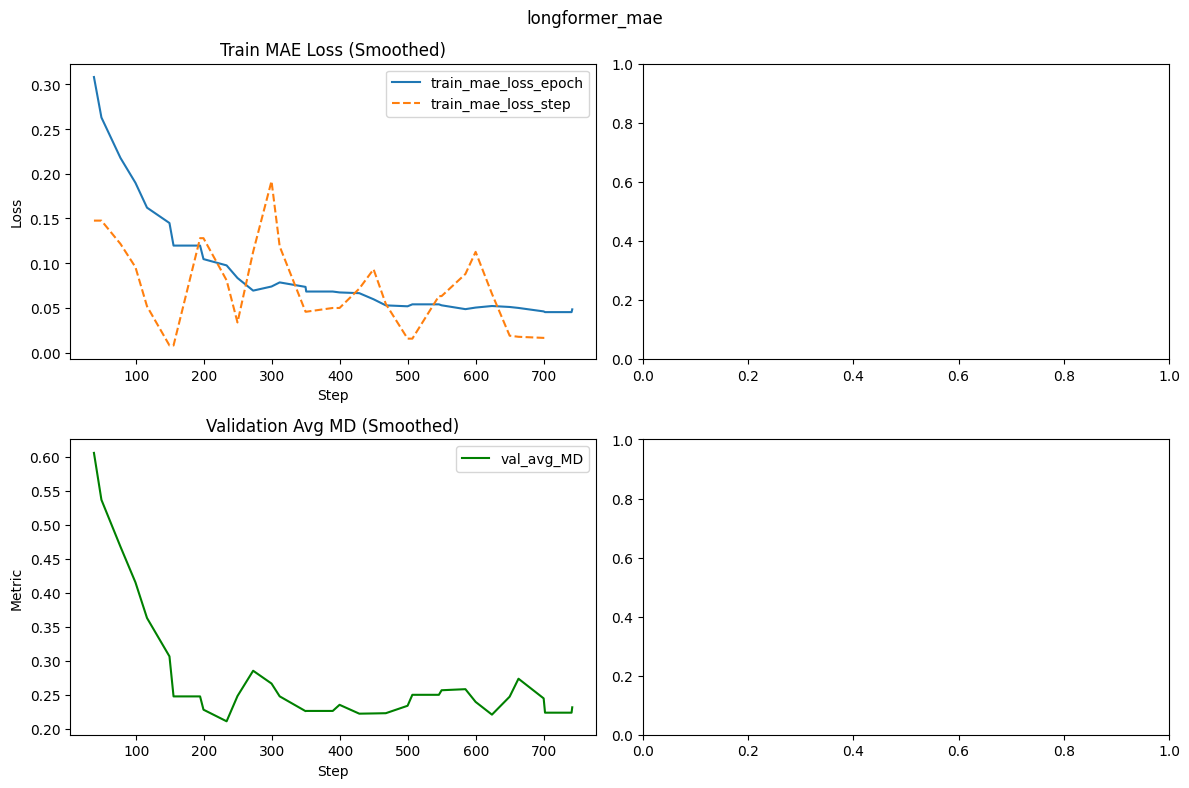

(312, 1)


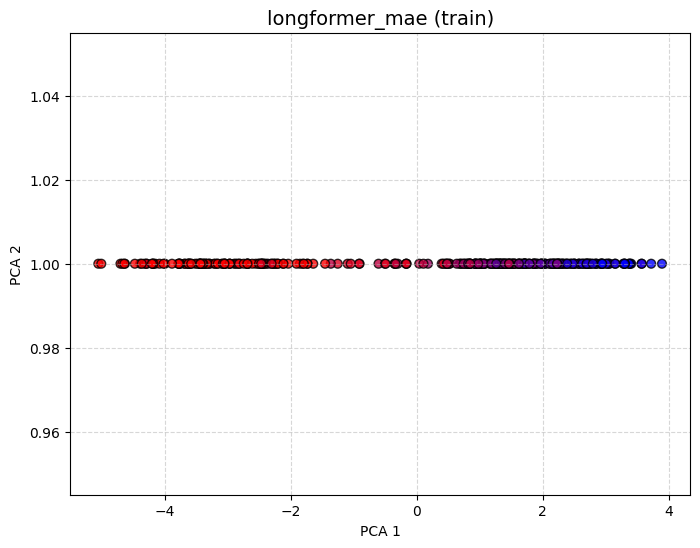

(78, 1)


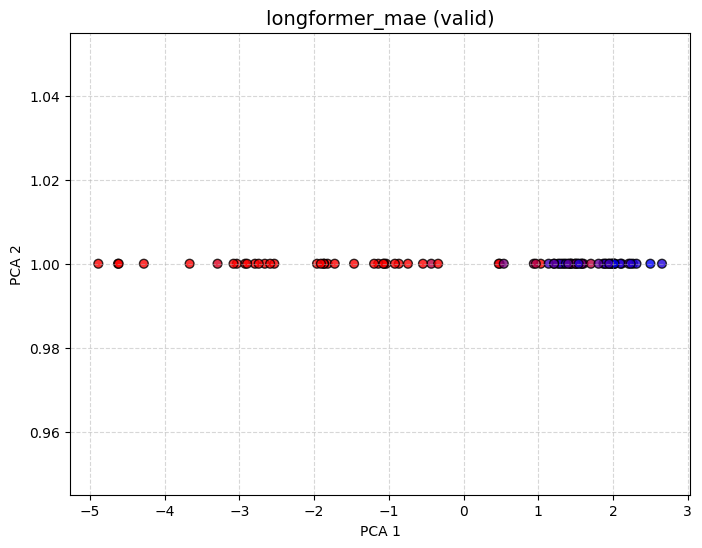

(98, 1)


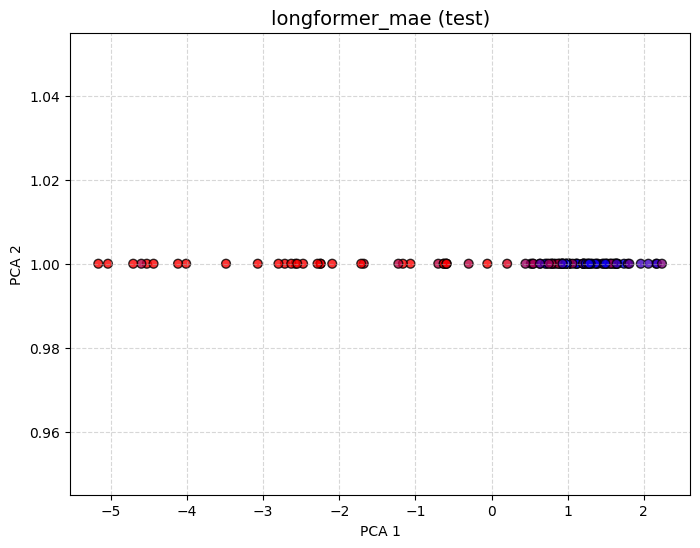

In [26]:
model_name = "allenai/longformer-base-4096"
model = EncoderBasedClassifier.load_from_checkpoint(f"./checkpoints/longformer_mae.ckpt")
df_train, df_valid, df_test = get_embeddings(model, exp='longformer_mae', force=False)
load_and_plot_training_log("./logs/longformer_mae/version_1/metrics.csv", loss="scl", smoothing_window=3, finetune=False)
visualize_softlabel_embeddings(df_train, 'longformer_mae', "train", pca=True)
visualize_softlabel_embeddings(df_valid, 'longformer_mae', "valid", pca=True)
visualize_softlabel_embeddings(df_test, 'longformer_mae', "test", pca=True)

Map: 100%|██████████| 312/312 [00:00<00:00, 819.48 examples/s]


dataset column names ['text', 'soft_label', 'input_ids', 'attention_mask']


Map: 100%|██████████| 98/98 [00:00<00:00, 886.32 examples/s]


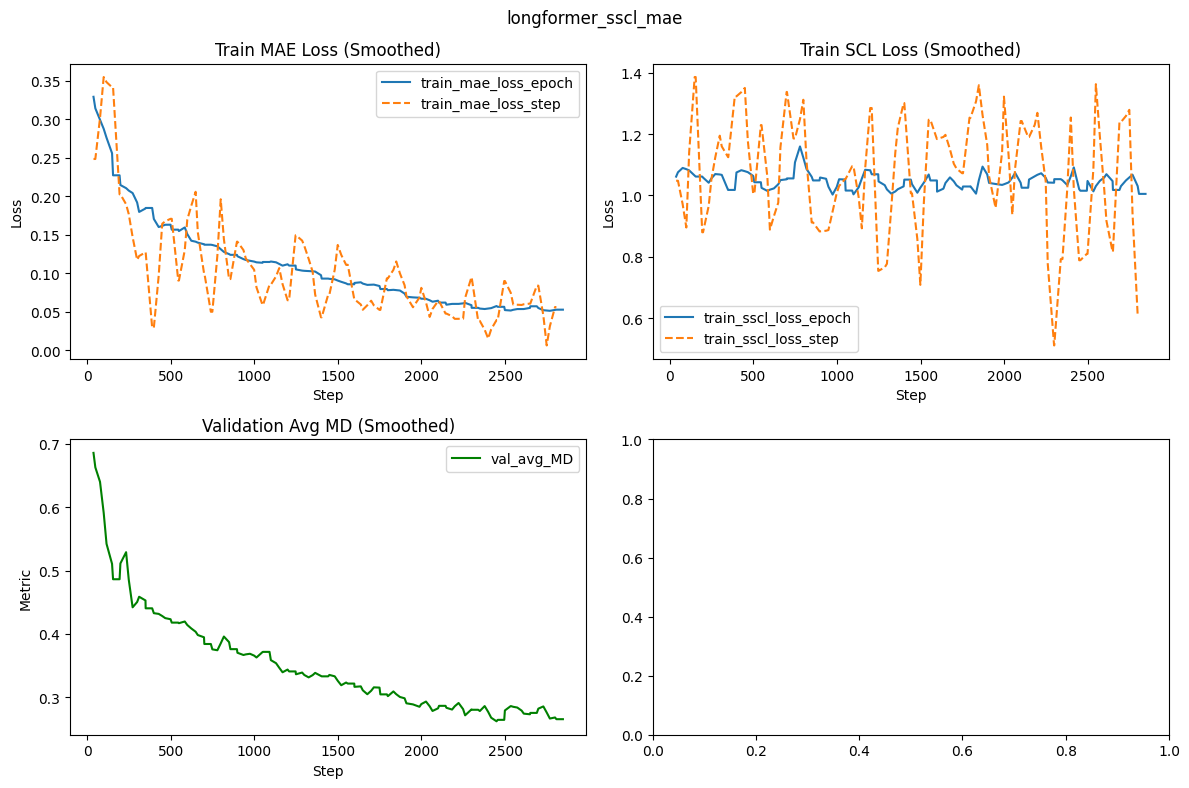

(312, 1)


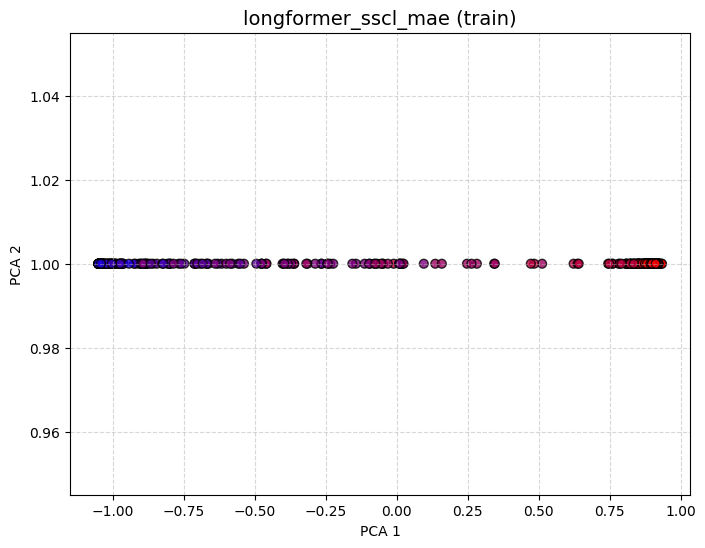

(78, 1)


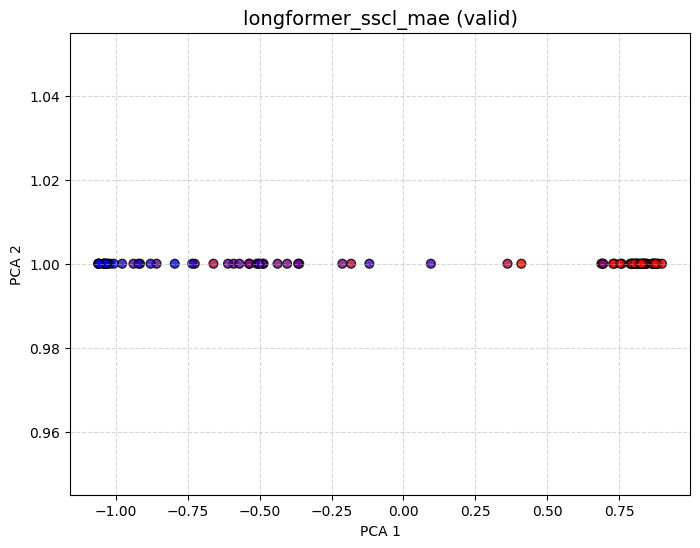

(98, 1)


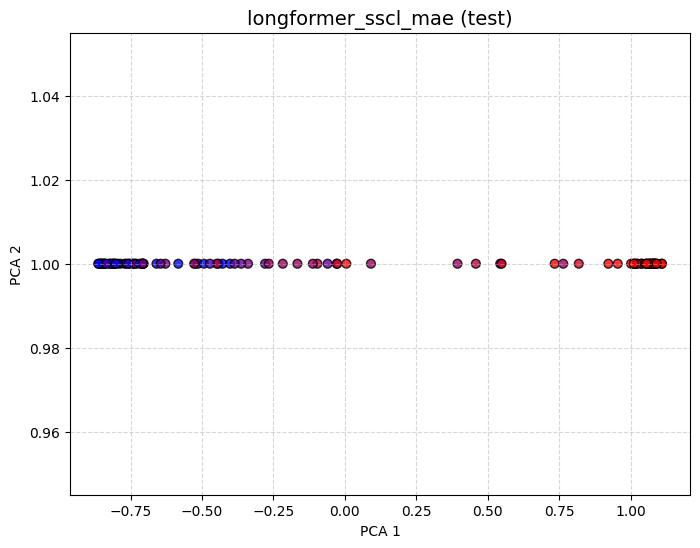

In [27]:
model_name = "allenai/longformer-base-4096"
model = ContrastiveClassifier.load_from_checkpoint(f"./checkpoints/longformer_sscl_mae.ckpt")
df_train, df_valid, df_test = get_embeddings(model, exp='longformer_sscl_mae', force=False)
load_and_plot_training_log("./logs/longformer_sscl_mae/version_1/metrics.csv", loss="sscl", smoothing_window=3, finetune=False)
visualize_softlabel_embeddings(df_train, 'longformer_sscl_mae', "train", pca=True)
visualize_softlabel_embeddings(df_valid, 'longformer_sscl_mae', "valid", pca=True)
visualize_softlabel_embeddings(df_test, 'longformer_sscl_mae', "test", pca=True)

Map: 100%|██████████| 312/312 [00:00<00:00, 850.49 examples/s]


dataset column names ['text', 'soft_label', 'input_ids', 'attention_mask']


Map: 100%|██████████| 98/98 [00:00<00:00, 858.64 examples/s]


(312, 1)


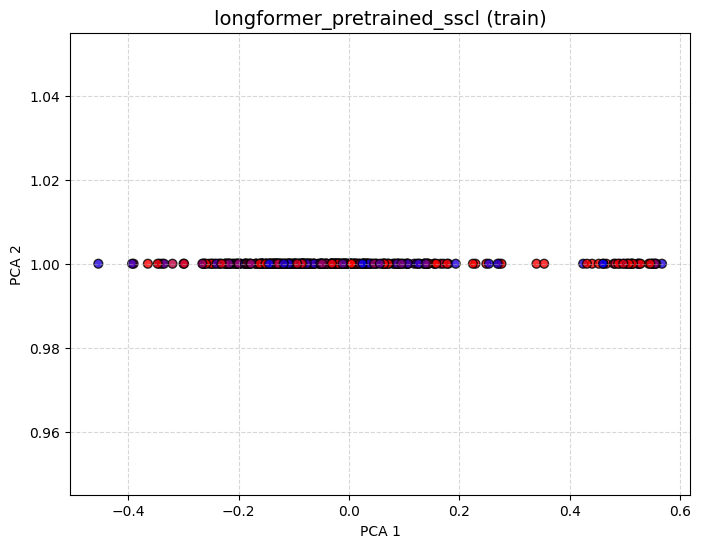

(78, 1)


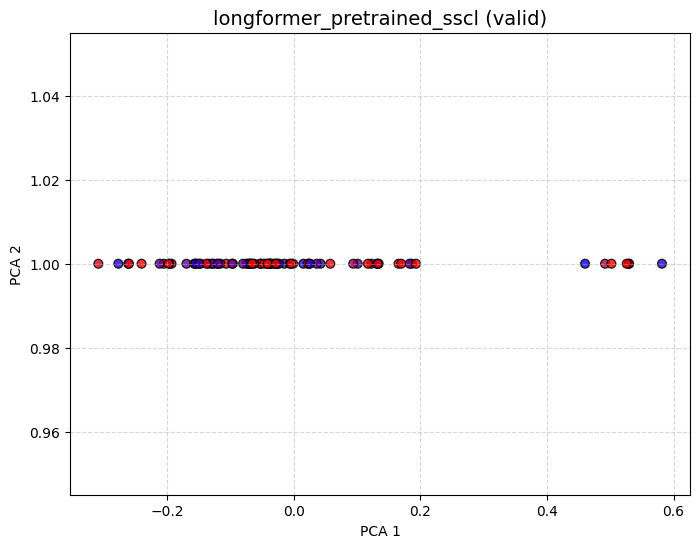

(98, 1)


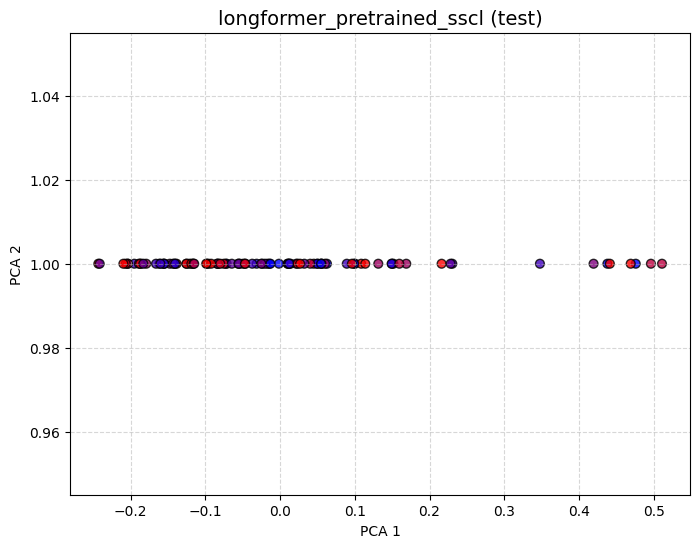

In [28]:
model_name = "allenai/longformer-base-4096"
model = ContrastiveClassifier.load_from_checkpoint(f"./checkpoints/longformer_pretrained_sscl.ckpt")
df_train, df_valid, df_test = get_embeddings(model, exp='longformer_pretrained_sscl', force=False)
#load_and_plot_training_log("./logs/longformer_pretrained_sscl/version_0/metrics.csv", loss="sscl", smoothing_window=3, finetune=False)
visualize_softlabel_embeddings(df_train, 'longformer_pretrained_sscl', "train", pca=True)
visualize_softlabel_embeddings(df_valid, 'longformer_pretrained_sscl', "valid", pca=True)
visualize_softlabel_embeddings(df_test, 'longformer_pretrained_sscl', "test", pca=True)

Map: 100%|██████████| 312/312 [00:00<00:00, 871.15 examples/s]


dataset column names ['text', 'soft_label', 'input_ids', 'attention_mask']


Map: 100%|██████████| 98/98 [00:00<00:00, 885.44 examples/s]


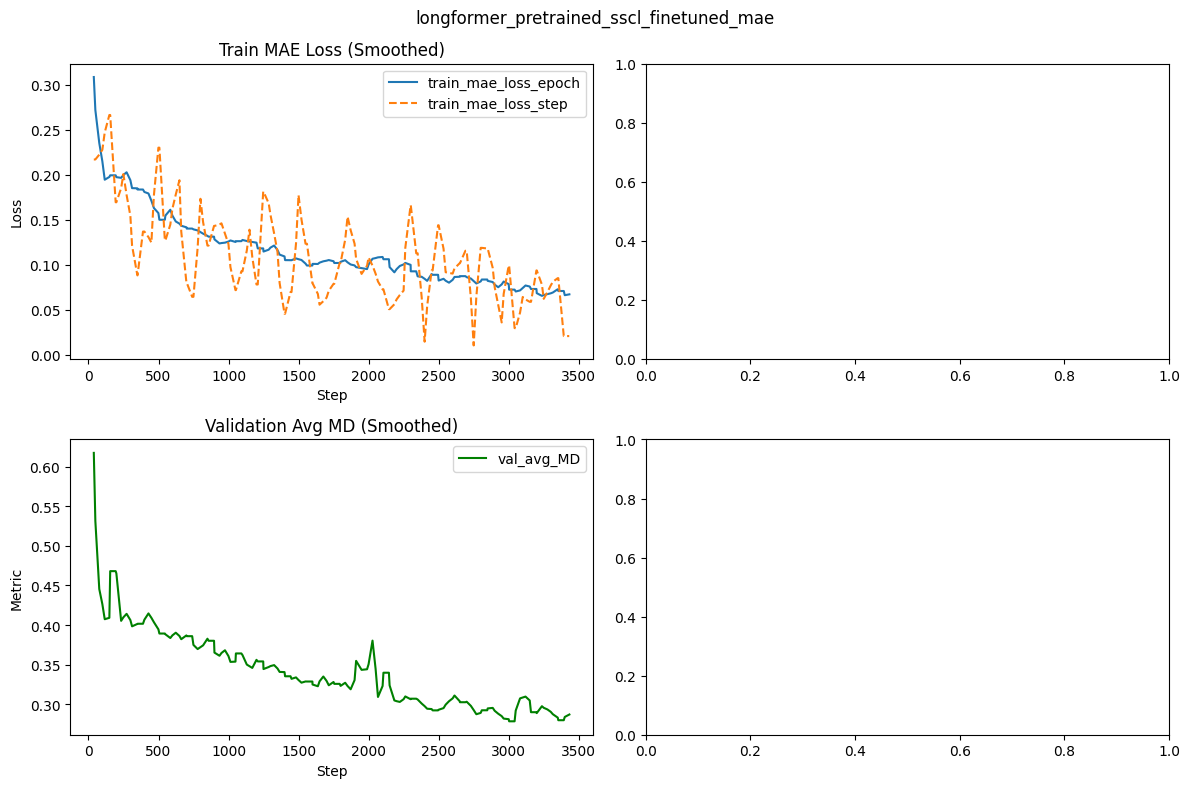

(312, 1)


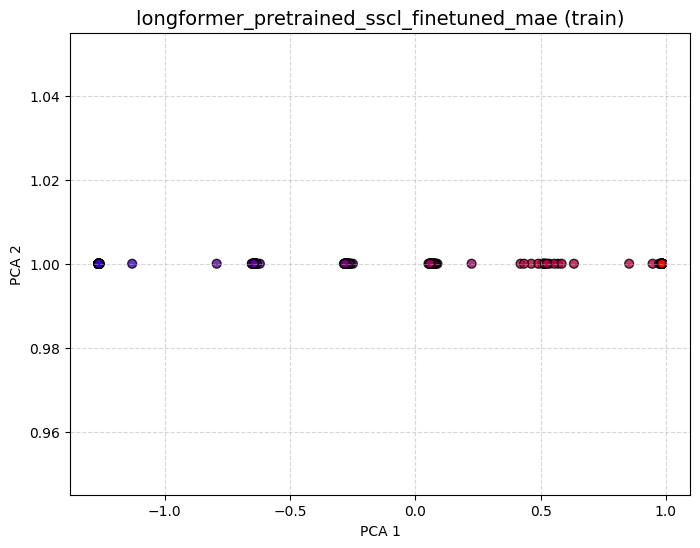

(78, 1)


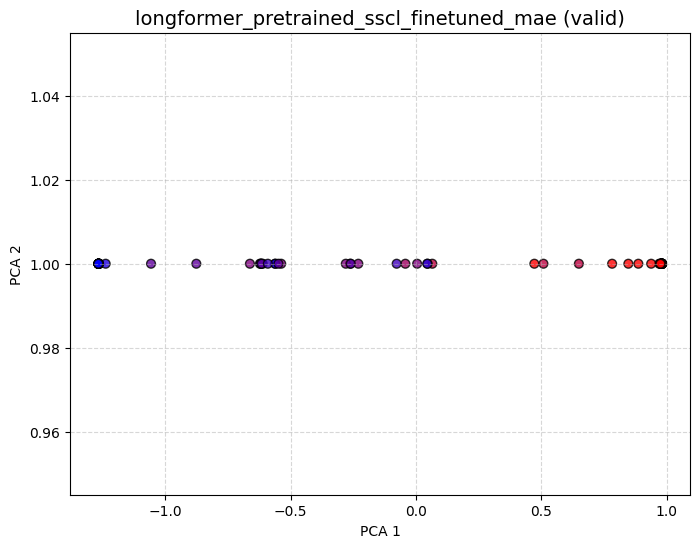

(98, 1)


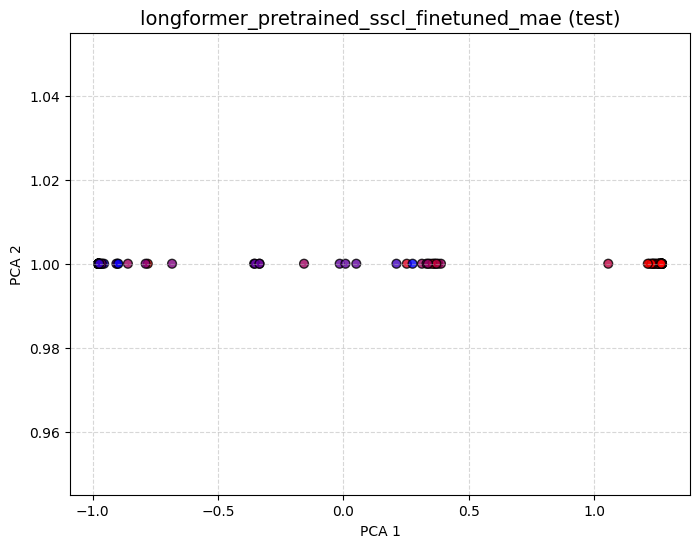

In [29]:
model_name = "allenai/longformer-base-4096"
model = FinetuningClassifier.load_from_checkpoint(f"./checkpoints/longformer_pretrained_sscl_finetuned_mae.ckpt")
df_train, df_valid, df_test = get_embeddings(model, exp='longformer_pretrained_sscl_finetuned_mae', force=False)
load_and_plot_training_log("./logs/longformer_pretrained_sscl_finetuned_mae/version_11/metrics.csv", loss="sscl", smoothing_window=3, finetune=False)
visualize_softlabel_embeddings(df_train, 'longformer_pretrained_sscl_finetuned_mae', "train", pca=True)
visualize_softlabel_embeddings(df_valid, 'longformer_pretrained_sscl_finetuned_mae', "valid", pca=True)
visualize_softlabel_embeddings(df_test, 'longformer_pretrained_sscl_finetuned_mae', "test", pca=True)

Map: 100%|██████████| 312/312 [00:00<00:00, 844.61 examples/s]


dataset column names ['text', 'soft_label', 'input_ids', 'attention_mask']


Map: 100%|██████████| 98/98 [00:00<00:00, 855.56 examples/s]


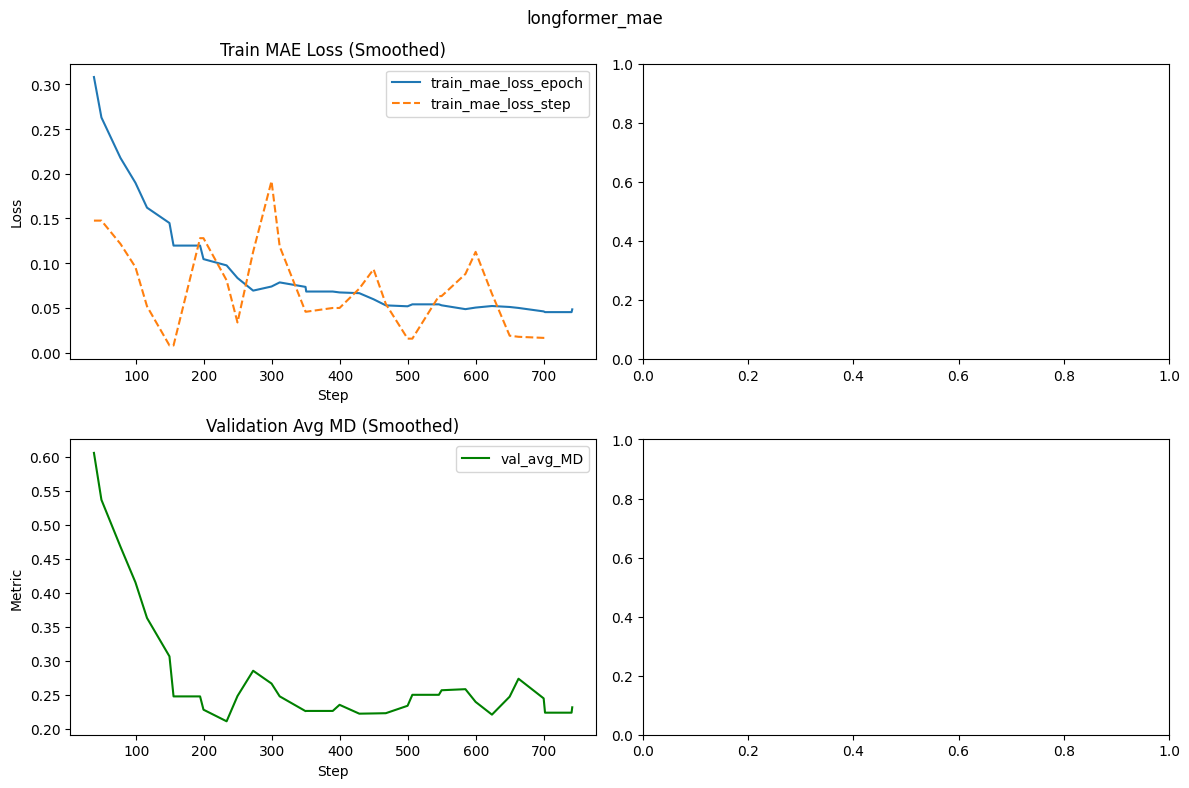

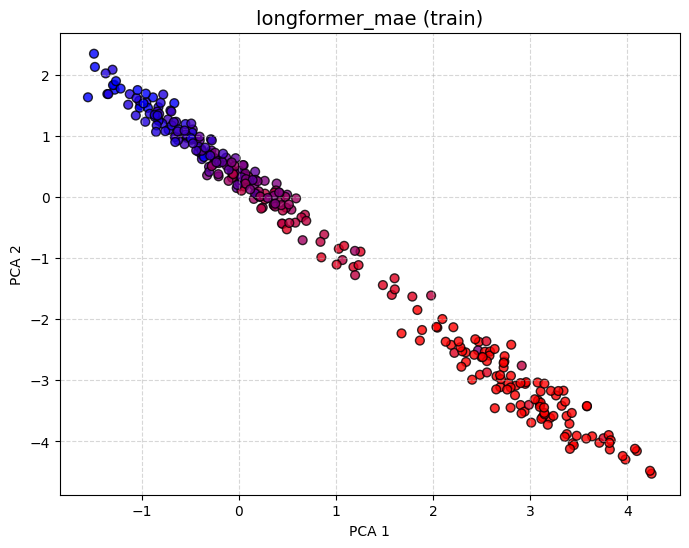

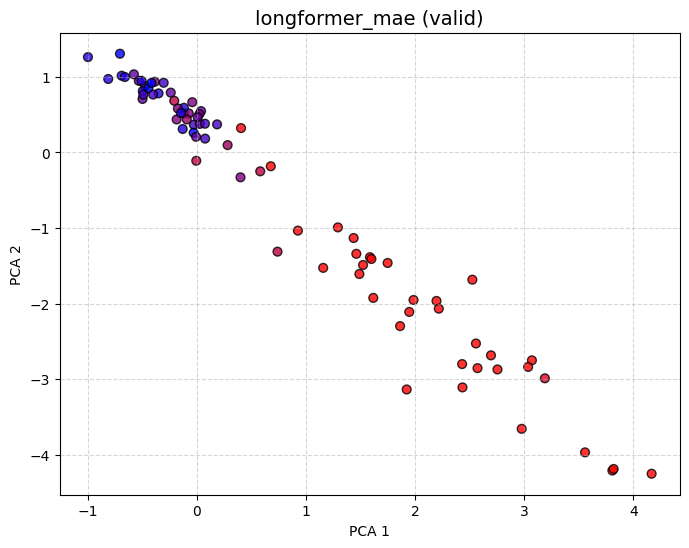

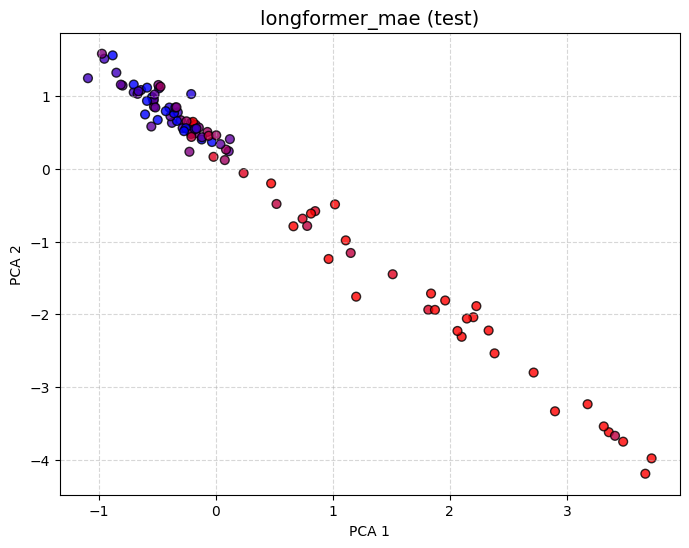

In [10]:
model_name = "allenai/longformer-base-4096"
model = EncoderBasedClassifier.load_from_checkpoint(f"./checkpoints/longformer_mae.ckpt")
df_train, df_valid, df_test = get_embeddings(model, exp='longformer_mae', force=True)
load_and_plot_training_log("./logs/longformer_mae/version_1/metrics.csv", loss="scl", smoothing_window=3, finetune=False)
visualize_softlabel_embeddings(df_train, 'longformer_mae', "train", pca=False)
visualize_softlabel_embeddings(df_valid, 'longformer_mae', "valid", pca=False)
visualize_softlabel_embeddings(df_test, 'longformer_mae', "test", pca=False)

In [62]:
csv_path = '../../../data/annotated/task_2_annotation.csv'
df = pd.read_csv(csv_path)
print(df)
df['feature_six'] = df['feature_six'].str.replace('*', '{}', regex=False)
df['feature_six'] = df['feature_six'].apply(ast.literal_eval)

df_unaggregated = df.pivot(index='item_id', columns='annotator', values='feature_six')
df_unaggregated.columns = [f'annotation_{col}' for col in df_unaggregated.columns]
df_unaggregated["text"] = df.text
df_unaggregated

     annotator  item_id                                               text  \
0           11        1  New Central Bank Chief Named In Argentina\n\n ...   
1           11       35  Analysts - Bank Of Canada Rate -2-\n\n \n\n  B...   
2           11       36  CPI Data Show Inflation Ignoring Recession Tal...   
3           11       64  German State Central Banker Sees Scant Room Fo...   
4           11       65  China Extends Two-Year Austerity Program\n\n \...   
..         ...      ...                                                ...   
411         14      458  Mekonomen: Interim report January - June 2022\...   
412         14      470  OPEC+ to Weigh Production Cut to Bolster Oil P...   
413         14      472  Global Forex and Fixed Income Roundup: Market ...   
414         14      486  The Fed and the Markets Disagree on Wages and ...   
415         14      488  Mondelez International 4Q Sales Climb on Highe...   

                                               triples  \
0    

,annotation_11,annotation_12,annotation_13,annotation_14,text
item_id,,,,,
1,"{(Monetary Policy, Increases, Inflation)}","{(Monetary Policy, Increases, Inflation)}","{(Monetary Policy, Increases, Inflation)}","{(Monetary Policy, Increases, Inflation)}",Analysts - Bank Of Canada Rate -2-\n\n \n\n B...
35,"{(Wages, Increases, Inflation)}","{(Wages, Increases, Inflation)}","{(Wages, Increases, Inflation)}","{(Inflation, Decreases, Inflation)}",WSJ(5/16) Milk Prices Pressure Food Firms\n\n ...
36,"{(Medical Costs, Increases, Inflation), (Tax I...","{(Medical Costs, Increases, Inflation), (Energ...","{(Medical Costs, Increases, Inflation)}","{(Tax Increases, Increases, Inflation), (Energ...",UPDATE: Colombia Central Bank Ups Key Rate 25 ...
64,"{(Wages, Increases, Inflation)}","{(Demand (residual), Increases, Inflation), (M...","{(Demand (residual), Increases, Inflation), (W...","{(Inflation, Increases, Inflation), (Demand (r...",Chile Central Bank Holds Key Rate Steady At 8....
65,"{(Government Debt, Increases, Inflation), (Mon...","{(Pent-up Demand, Increases, Inflation), (Supp...","{(Government Spending, Increases, Inflation), ...","{(Monetary Policy, Decreases, Inflation)}",The Stock Market Had a Better Day Than it Seem...
...,...,...,...,...,...
458,"{(War, Increases, Inflation)}","{(War, Increases, Inflation)}","{(War, Increases, Inflation)}",{},NaN
470,"{(Supply (residual), Increases, Inflation)}","{(Supply (residual), Increases, Inflation), (E...","{(Supply (residual), Increases, Inflation)}","{(Energy Prices, Increases, Inflation)}",NaN
472,"{(Supply Chain Issues, Increases, Inflation), ...","{(Supply Chain Issues, Decreases, Inflation), ...","{(Supply Chain Issues, Decreases, Inflation), ...","{(Supply Chain Issues, Decreases, Inflation), ...",NaN


In [73]:
from itertools import chain
unique_labels = list(set(chain(*[value for value in df['feature_six'].values])))
unique_labels

[('Pent-up Demand', 'Increases', 'Inflation'),
 ('Wages', 'Decreases', 'Inflation'),
 ('Supply Chain Issues', 'Decreases', 'Inflation'),
 ('Wages', 'Increases', 'Inflation'),
 ('Transportation Costs', 'Increases', 'Inflation'),
 ('Base Effect', 'Decreases', 'Inflation'),
 ('Supply Chain Issues', 'Increases', 'Inflation'),
 ('Supply (residual)', 'Decreases', 'Inflation'),
 ('Transportation Costs', 'Decreases', 'Inflation'),
 ('Base Effect', 'Increases', 'Inflation'),
 ('Supply (residual)', 'Increases', 'Inflation'),
 ('Exchange Rates', 'Decreases', 'Inflation'),
 ('Government Debt', 'Decreases', 'Inflation'),
 ('Labor Shortage', 'Decreases', 'Inflation'),
 ('Government Debt', 'Increases', 'Inflation'),
 ('Labor Shortage', 'Increases', 'Inflation'),
 ('Food Prices', 'Increases', 'Inflation'),
 ('Monetary Policy', 'Decreases', 'Inflation'),
 ('Food Prices', 'Decreases', 'Inflation'),
 ('Monetary Policy', 'Increases', 'Inflation'),
 ('Energy Prices', 'Decreases', 'Inflation'),
 ('Energy Pr

,annotation_11,annotation_12,annotation_13,annotation_14
item_id,,,,
1,Increases,Increases,Increases,Increases
2,Increases,Increases,Increases,Decreases
3,Increases,Mixed,Increases,Increases
4,Increases,Mixed,Increases,Increases
5,Mixed,Mixed,Increases,Decreases
...,...,...,...,...
98,Increases,Increases,Increases,Increases
101,Increases,Increases,Increases,Increases
102,Increases,Mixed,Mixed,Mixed


In [96]:
from collections import Counter


def get_majority_vote(df):
    col_names = [col for col in df.columns if col.startswith("annotation")]
    
    majority_labels = []
    has_winner = 0

    for i, row in enumerate(df[col_names].values):
        row = list(chain(*row))
        counter = Counter(row)
        most_common = [count for count in counter.most_common() if count[1] > 1]
        if not most_common:
            majority_labels.append(None)
        else:
            print(most_common)
            # Get highest frequency count
            max_count = most_common[0][1]
            top_labels = [label for label, count in most_common if count == max_count]
            print(top_labels)
            # Handle tie-breaks
            if len(top_labels) == 1:
                majority_labels.append([top_labels[0]])  # Clear winner
                has_winner += 1
            else:
                majority_labels.append(top_labels)  # no winner
    print(f"has winner ratio: {has_winner/len(df)}\n")
    return majority_labels

In [106]:
df_unaggregated = df_unaggregated.dropna()
df_unaggregated["aggregated_label"] = get_majority_vote(df_unaggregated)
df_aggregated = df_unaggregated.dropna()

df_aggregated

[(('Monetary Policy', 'Increases', 'Inflation'), 4)]
[('Monetary Policy', 'Increases', 'Inflation')]
[(('Wages', 'Increases', 'Inflation'), 3)]
[('Wages', 'Increases', 'Inflation')]
[(('Medical Costs', 'Increases', 'Inflation'), 3), (('Tax Increases', 'Increases', 'Inflation'), 3), (('Energy Prices', 'Increases', 'Inflation'), 3)]
[('Medical Costs', 'Increases', 'Inflation'), ('Tax Increases', 'Increases', 'Inflation'), ('Energy Prices', 'Increases', 'Inflation')]
[(('Wages', 'Increases', 'Inflation'), 3), (('Demand (residual)', 'Increases', 'Inflation'), 3)]
[('Wages', 'Increases', 'Inflation'), ('Demand (residual)', 'Increases', 'Inflation')]
[(('Monetary Policy', 'Decreases', 'Inflation'), 3), (('Government Debt', 'Increases', 'Inflation'), 2)]
[('Monetary Policy', 'Decreases', 'Inflation')]
[(('Tax Increases', 'Increases', 'Inflation'), 4), (('Wages', 'Increases', 'Inflation'), 3)]
[('Tax Increases', 'Increases', 'Inflation')]
[(('Government Spending', 'Increases', 'Inflation'), 2)

,annotation_11,annotation_12,annotation_13,annotation_14,text,aggregated_label
item_id,,,,,,
1,"{(Monetary Policy, Increases, Inflation)}","{(Monetary Policy, Increases, Inflation)}","{(Monetary Policy, Increases, Inflation)}","{(Monetary Policy, Increases, Inflation)}",Analysts - Bank Of Canada Rate -2-\n\n \n\n B...,"[(Monetary Policy, Increases, Inflation)]"
35,"{(Wages, Increases, Inflation)}","{(Wages, Increases, Inflation)}","{(Wages, Increases, Inflation)}","{(Inflation, Decreases, Inflation)}",WSJ(5/16) Milk Prices Pressure Food Firms\n\n ...,"[(Wages, Increases, Inflation)]"
36,"{(Medical Costs, Increases, Inflation), (Tax I...","{(Medical Costs, Increases, Inflation), (Energ...","{(Medical Costs, Increases, Inflation)}","{(Tax Increases, Increases, Inflation), (Energ...",UPDATE: Colombia Central Bank Ups Key Rate 25 ...,"[(Medical Costs, Increases, Inflation), (Tax I..."
64,"{(Wages, Increases, Inflation)}","{(Demand (residual), Increases, Inflation), (M...","{(Demand (residual), Increases, Inflation), (W...","{(Inflation, Increases, Inflation), (Demand (r...",Chile Central Bank Holds Key Rate Steady At 8....,"[(Wages, Increases, Inflation), (Demand (resid..."
65,"{(Government Debt, Increases, Inflation), (Mon...","{(Pent-up Demand, Increases, Inflation), (Supp...","{(Government Spending, Increases, Inflation), ...","{(Monetary Policy, Decreases, Inflation)}",The Stock Market Had a Better Day Than it Seem...,"[(Monetary Policy, Decreases, Inflation)]"
...,...,...,...,...,...,...
408,"{(Food Prices, Increases, Inflation), (Tax Inc...","{(Energy Prices, Increases, Inflation), (Pande...","{(Food Prices, Increases, Inflation), (Monetar...","{(Food Prices, Increases, Inflation), (Monetar...",Growth Fears Challenge Soaring Oil Prices -- W...,"[(Monetary Policy, Increases, Inflation)]"
409,"{(Food Prices, Increases, Inflation), (Energy ...","{(Food Prices, Increases, Inflation), (Supply ...","{(Supply (residual), Increases, Inflation)}",{},Turkey Annual Inflation Rate Neared 80% in Jun...,"[(Food Prices, Increases, Inflation), (Energy ..."
412,"{(Supply Chain Issues, Increases, Inflation), ...","{(Supply Chain Issues, Increases, Inflation), ...","{(Pent-up Demand, Increases, Inflation), (Supp...","{(Supply Chain Issues, Increases, Inflation), ...",OPEC+ to Weigh Production Cut to Bolster Oil P...,"[(Supply Chain Issues, Increases, Inflation), ..."


In [108]:
def label2id_map(df_aggregated):
    return {label: i for i, label in enumerate(get_unique_labels(df_aggregated))}

def get_unique_labels(df):
    return list(set(chain(*[value for value in df["aggregated_label"].values])))

In [109]:
label2id = label2id_map(df_aggregated)
label2id

{('Pent-up Demand', 'Increases', 'Inflation'): 0,
 ('Wages', 'Decreases', 'Inflation'): 1,
 ('Wages', 'Increases', 'Inflation'): 2,
 ('Supply Chain Issues', 'Increases', 'Inflation'): 3,
 ('Supply (residual)', 'Decreases', 'Inflation'): 4,
 ('Supply (residual)', 'Increases', 'Inflation'): 5,
 ('Exchange Rates', 'Decreases', 'Inflation'): 6,
 ('Labor Shortage', 'Increases', 'Inflation'): 7,
 ('Food Prices', 'Increases', 'Inflation'): 8,
 ('Monetary Policy', 'Decreases', 'Inflation'): 9,
 ('Food Prices', 'Decreases', 'Inflation'): 10,
 ('Monetary Policy', 'Increases', 'Inflation'): 11,
 ('Energy Prices', 'Decreases', 'Inflation'): 12,
 ('Energy Prices', 'Increases', 'Inflation'): 13,
 ('Exchange Rates', 'Increases', 'Inflation'): 14,
 ('Price-Gouging', 'Decreases', 'Inflation'): 15,
 ('Climate', 'Increases', 'Inflation'): 16,
 ('Mismanagement', 'Increases', 'Inflation'): 17,
 ('Price-Gouging', 'Increases', 'Inflation'): 18,
 ('Demand (residual)', 'Increases', 'Inflation'): 19,
 ('Inflati

In [116]:
[[label2id[label] for label in labels] for labels in df_aggregated['aggregated_label']]

[[11],
 [2],
 [23, 25, 13],
 [2, 19],
 [9],
 [25],
 [26],
 [8, 13],
 [0],
 [2],
 [17],
 [12, 6],
 [27, 13, 24],
 [2],
 [11, 2],
 [8],
 [2],
 [25],
 [2],
 [13, 7],
 [12, 10],
 [9],
 [19],
 [13, 2],
 [10],
 [13],
 [15, 13],
 [22],
 [11],
 [14],
 [8, 21, 9],
 [10],
 [1],
 [9],
 [7],
 [20],
 [8],
 [18],
 [14, 18],
 [13],
 [5],
 [8, 13],
 [26],
 [11],
 [8, 13],
 [13],
 [3, 13],
 [14],
 [8],
 [8, 13, 9],
 [13],
 [8, 13],
 [13],
 [13],
 [13],
 [8],
 [12, 10, 4],
 [13],
 [13, 9],
 [12, 10],
 [12],
 [9],
 [13],
 [2, 7],
 [16],
 [26, 0],
 [0, 13],
 [0],
 [3, 13],
 [19],
 [3],
 [3],
 [11],
 [8, 13, 5],
 [3, 5],
 [7],
 [20]]